# Unit 6. Essential Deep Learning Tips & Tricks

# 6.2 Learning Rates and Learning Rate Schedulers

## Part 3. Using an Automatic Learning Rate Finder

In [11]:
%load_ext watermark
%watermark -p torch,lightning --conda

torch    : 2.0.1
lightning: 2.0.9

conda environment: n/a



In [5]:
import lightning as L
import torch
from lightning.pytorch.loggers import CSVLogger
import torchmetrics
import torch.nn.functional as F
from shared_utilities import CustomDataModule, LightningModel, PyTorchMLP

In [8]:
!git commit -m "from cloud"
!git push

[main a78c0e1] from cloud
 1 file changed, 57 insertions(+), 3 deletions(-)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 1.09 KiB | 559.00 KiB/s, done.
Total 5 (delta 4), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/ARKA1112/dl-fundamentals
   3a0d171..a78c0e1  main -> main


In [9]:
# Here we import two modules which are LightningModel and PyTorchMLP

class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.save_hyperparameters(ignore = ['model'])

        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=2)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=2)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        
        loss = F.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_labels, predicted_labels


    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log("train_loss", loss)
        self.train_acc(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, prog_bar = True, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log('val_loss', loss, prog_bar =True)
        self.val_acc(predicted_labels, true_labels)
        self.log('val_acc', self.val_acc, prog_bar = True)

    def test_step(self, batch, batch_idx):
        _, true_labels, predicted_labels = self._shared_step(batch)

        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc)

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr = self.learning_rate)
        return optimizer

In [10]:
torch.manual_seed(123)
dm = CustomDataModule()

pytorch_model = PyTorchMLP(num_features=100, num_classes=2)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

## Lightning < 2.0

```python

trainer = L.Trainer(
    max_epochs=100,
    auto_lr_find=True,  # New!!!
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),    
    deterministic=True,
)

results = trainer.tune(model=lightning_model, datamodule=dm)
```

## Lightning >= 2.0

In [ ]:
# Steps are as follows,
# Import the tuner package

# Create a trainer instance> create a tuner instance> then find the lr_rate using the tuner

In [ ]:
# SELF

In [12]:
from lightning.pytorch.tuner import Tuner

trainer = L.Trainer(
    max_epochs=100,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),    
    deterministic=True,
)


# Create a Tuner
tuner = Tuner(trainer)

# finds learning rate automatically
# sets hparams.lr or hparams.learning_rate to that learning rate
lr_finder = tuner.lr_find(lightning_model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 440.43it/s]
Learning rate set to 0.10964781961431852
Restoring states from the checkpoint path at /workspaces/dl-fundamentals/unit06-dl-tips/6.2-learning-rates/.lr_find_3c37fced-b823-4c2a-91e1-031e68b66246.ckpt
Restored all states from the checkpoint at /workspaces/dl-fundamentals/unit06-dl-tips/6.2-learning-rates/.lr_find_3c37fced-b823-4c2a-91e1-031e68b66246.ckpt


In [21]:
#SELF
lr_finder.suggestion()

0.10964781961431852

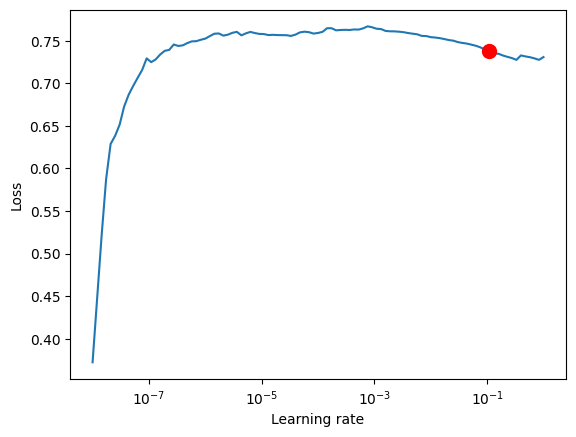

In [22]:
fig = lr_finder.plot(suggest=True)
#fig.savefig("lr_suggest.pdf")

In [23]:
# get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

0.10964781961431852


In [7]:
# update hparams of the model
lightning_model.learning_rate = new_lr

In [8]:
trainer.fit(model=lightning_model, datamodule=dm)

/Users/sebastianraschka/Desktop/lightning-master/src/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory logs/my-model/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchMLP         | 15.3 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
15.3 K    Trainable params
0         Non-trainable params
15.3 K    Total params
0.061     Total estimated model params size (MB)
/Users/sebastianraschka/Desktop/lightning-master/src/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory logs/my-model/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank

Sanity Checking: 0it [00:00, ?it/s]

/Users/sebastianraschka/Desktop/lightning-master/src/lightning/pytorch/trainer/connectors/data_connector.py:208: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/sebastianraschka/Desktop/lightning-master/src/lightning/pytorch/trainer/connectors/data_connector.py:208: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


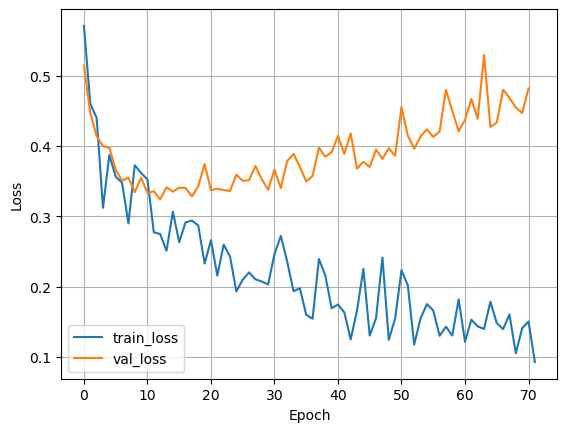

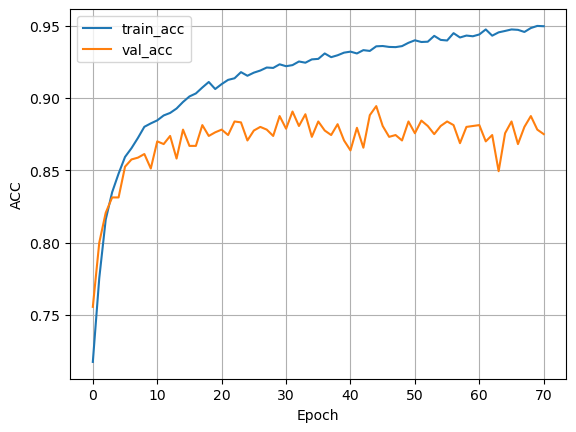

In [9]:
### Plot
import matplotlib.pyplot as plt
import pandas as pd

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)

plt.savefig("suggest_loss.pdf")

df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.savefig("suggest_acc.pdf")

plt.show()

In [10]:
trainer.test(model=lightning_model, dataloaders=dm)

/Users/sebastianraschka/Desktop/lightning-master/src/lightning/pytorch/trainer/connectors/data_connector.py:208: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8550000190734863     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.8550000190734863}]